# Download dataset

In [1]:
!gdown --id 14gf8bcym_lTcvjZQmg8kwq3aXkENBxMQ
!unzip tsukuba.zip -d tsukuba

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=14gf8bcym_lTcvjZQmg8kwq3aXkENBxMQ
To: /content/tsukuba.zip
100% 354k/354k [00:00<00:00, 28.6MB/s]
Archive:  tsukuba.zip
mapname:  conversion of  failed
 extracting: tsukuba/left.png        
 extracting: tsukuba/right.png       
 extracting: tsukuba/groundtruth.png  


In [2]:
!gdown --id 1wxmiUdqMciuTOs0ouKEISl8-iTVXdOWn
!unzip Aloe_images.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1wxmiUdqMciuTOs0ouKEISl8-iTVXdOWn
To: /content/Aloe_images.zip
100% 1.32M/1.32M [00:00<00:00, 45.8MB/s]
Archive:  Aloe_images.zip
  inflating: Aloe/Aloe_left_1.png    
  inflating: Aloe/Aloe_right_3.png   
  inflating: Aloe/Aloe_right_1.png   
  inflating: Aloe/Aloe_right_2.png   
  inflating: Aloe/Disparity_map_corr.png  


# Set up dependencies

In [3]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Problem 1: Pixel-wise matching with L1 and L2 distance

In [4]:
def l1_distance(x, y):
    return abs(x - y)

def l2_distance(x, y):
    return (x - y) ** 2

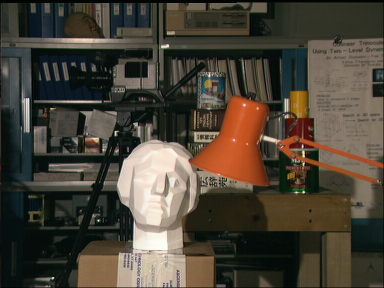

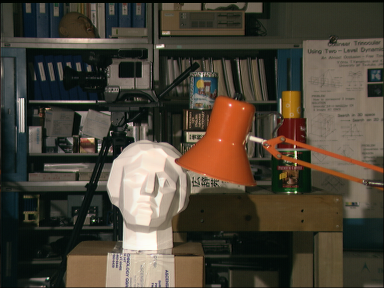

In [5]:
left_img_path = 'tsukuba/left.png'
right_img_path = 'tsukuba/right.png'
disparity_range = 16

left = cv2.imread(left_img_path)
right = cv2.imread(right_img_path)

cv2_imshow(left)
cv2_imshow(right)

In [14]:
def pixel_wise_matching(left_img, right_img, disparity_range, distance_fn, save_result=True):
    # Read left, right images then convert to grayscale
    left  = cv2.imread(left_img, 0)
    right = cv2.imread(right_img, 0)

    left  = left.astype(np.float32)
    right = right.astype(np.float32)

    height, width = left.shape[:2]

    # Create blank disparity map
    depth = np.zeros((height, width), np.uint8)
    scale = 16
    max_value = 255

    for y in range(height):
        for x in range(width):
            # Find j where cost has minimum value
            disparity = 0
            cost_min  = max_value

            for j in range(disparity_range):
                cost = max_value if (x - j) < 0 \
                                else distance_fn(int(left[y, x]), int(right[y, x - j]))

                if cost < cost_min:
                    cost_min  = cost
                    disparity = j

            # Let depth at (y, x) = j (disparity)
            # Multiply by a scale factor for visualization purpose
            depth[y, x] = disparity * scale

    if save_result == True:
        print('Saving result...')
        # Save results
        cv2.imwrite(f'pixel_wise_l1.png', depth)
        cv2.imwrite(f'pixel_wise_l1_color.png', cv2.applyColorMap(depth, cv2.COLORMAP_JET))

    print('Done.')

    return depth, cv2.applyColorMap(depth, cv2.COLORMAP_JET)

In [12]:
def pixel_wise_matching_l1(left_img, right_img, disparity_range, save_result=True):
    return pixel_wise_matching(left_img, right_img, disparity_range, l1_distance, save_result)

def pixel_wise_matching_l2(left_img, right_img, disparity_range, save_result=True):
    return pixel_wise_matching(left_img, right_img, disparity_range, l2_distance, save_result)

Saving result...
Done.


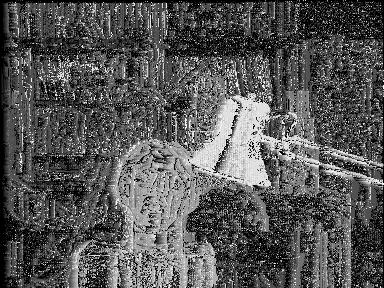

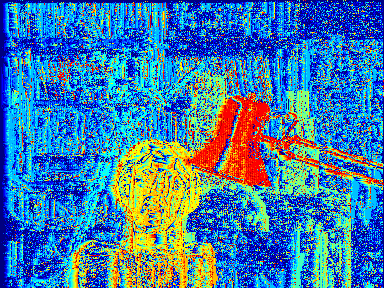

In [15]:
# L1 result
depth, color = pixel_wise_matching_l1(
    left_img_path,
    right_img_path,
    disparity_range,
    save_result=True
)
cv2_imshow(depth)
cv2_imshow(color)

Saving result...
Done.


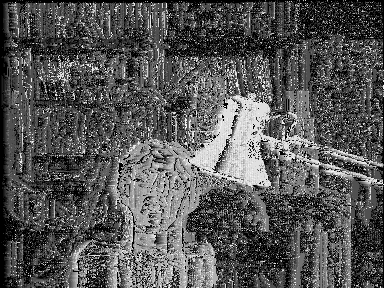

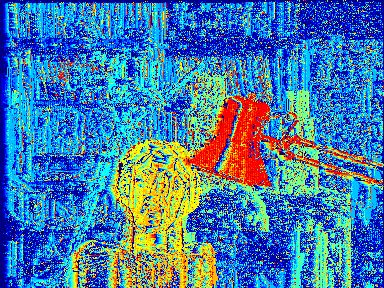

In [16]:
# L2 result
depth, color = pixel_wise_matching_l2(
    left_img_path,
    right_img_path,
    disparity_range,
    save_result=True
)
cv2_imshow(depth)
cv2_imshow(color)

# Problem 2: Window-based matching with L1 and L2 distance

In [22]:
from tqdm import tqdm

In [23]:
def window_based_matching(left_img, right_img, disparity_range, distance_fn, kernel_size=5, save_result=True):
    # Read left, right images then convert to grayscale
    left  = cv2.imread(left_img, 0)
    right = cv2.imread(right_img, 0)

    left  = left.astype(np.float32)
    right = right.astype(np.float32)

    height, width = left.shape[:2]

    # Create blank disparity map
    depth = np.zeros((height, width), np.uint8)

    kernel_half = int((kernel_size - 1) / 2)
    scale = 3
    max_value = 255 * 9

    for y in tqdm(range(kernel_half, height - kernel_half)):
        for x in range(kernel_half, width - kernel_half):
            # Find j where cost has minimum value
            disparity = 0
            cost_min  = 65534

            for j in range(disparity_range):
                total = 0
                value = 0

                for v in range(-kernel_half, kernel_half + 1):
                    for u in range(-kernel_half, kernel_half + 1):
                        value = max_value
                        if (x + u - j) >= 0:
                            value = distance_fn(
                                int(left[y + v, x + u]), int(right[y + v, (x + u) - j]))
                        total += value

                if total < cost_min:
                    cost_min = total
                    disparity = j

            # Let depth at (y, x) = j (disparity)
            # Multiply by a scale factor for visualization purpose
            depth[y, x] = disparity * scale

    if save_result == True:
        print('Saving result...')
        # Save results
        cv2.imwrite(f'window_based_l1.png', depth)
        cv2.imwrite(f'window_based_l1_color.png', cv2.applyColorMap(depth, cv2.COLORMAP_JET))

    print('Done.')

    return depth

In [24]:
def window_based_matching_l1(left_img, right_img, disparity_range, kernel_size=5, save_result=True):
  return window_based_matching(left_img, right_img, disparity_range, l1_distance, kernel_size=5, save_result=True)

def window_based_matching_l2(left_img, right_img, disparity_range, kernel_size=5, save_result=True):
  return window_based_matching(left_img, right_img, disparity_range, l2_distance, kernel_size=5, save_result=True)

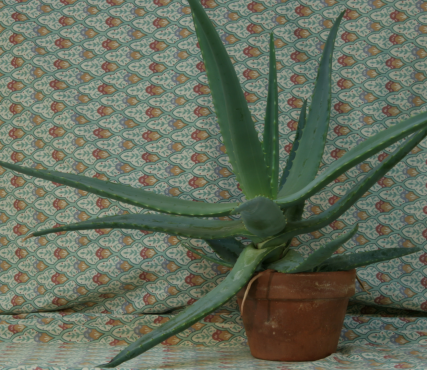

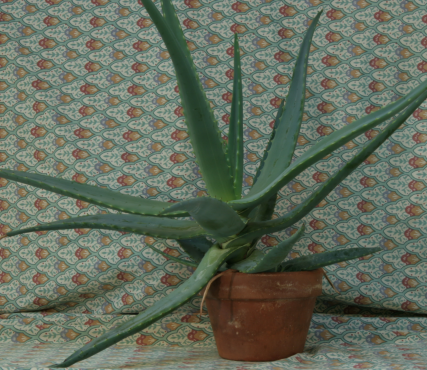

In [20]:
left_img_path = 'Aloe/Aloe_left_1.png'
right_img_path = 'Aloe/Aloe_right_1.png'
disparity_range = 64
kernel_size = 3

left = cv2.imread(left_img_path)
right = cv2.imread(right_img_path)

cv2_imshow(left)
cv2_imshow(right)

100%|██████████| 366/366 [04:19<00:00,  1.41it/s]

Saving result...
Done.


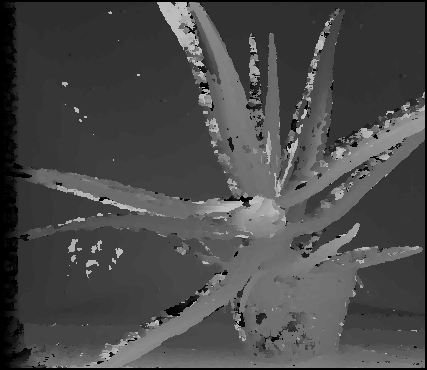

In [25]:
# L1 Result
depth = window_based_matching_l1(
    left_img_path,
    right_img_path,
    disparity_range,
    kernel_size=kernel_size,
    save_result=True
)

cv2_imshow(depth)

100%|██████████| 366/366 [05:32<00:00,  1.10it/s]

Saving result...
Done.


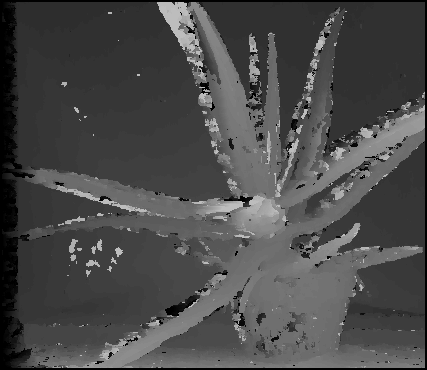

In [26]:
# L2 Result
depth = window_based_matching_l2(
    left_img_path,
    right_img_path,
    disparity_range,
    kernel_size=kernel_size,
    save_result=True
)

cv2_imshow(depth)

# Problem 3: Explain why solutions in problem 2 do not work well with inputs with different ilumination levels

L1 and L2 distance are highly susceptible to linear transformation, while ilumination change is considered as linear transformation. For example
- For $x=array([10,10])$ and $y=array([10,11])$, $L1(x,y)=1$ and $L2(x,y)=1$
- However, when $y_{prime}=y+5=array([15,16])$, $L1(x,y_{prime})=11$ and $L2(x,y_{prime})≈7.81$

In [30]:
x=np.array([10,10])
y=np.array([10,11])
y_prime=y+5
print(sum(y_prime-x), sum((y_prime-x)**2)**0.5)

11 7.810249675906654


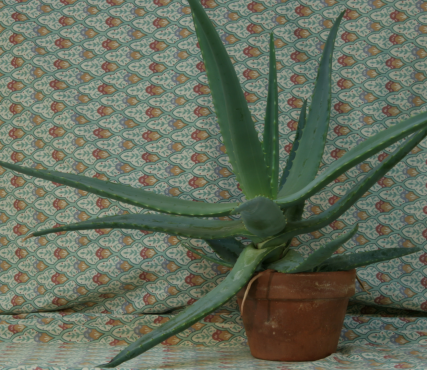

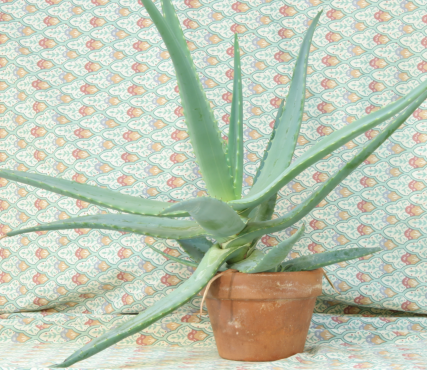

In [31]:
left_img_path = 'Aloe/Aloe_left_1.png'
right_img_path = 'Aloe/Aloe_right_2.png'
disparity_range = 64
kernel_size = 5

left = cv2.imread(left_img_path)
right = cv2.imread(right_img_path)

cv2_imshow(left)
cv2_imshow(right)

100%|██████████| 366/366 [04:32<00:00,  1.35it/s]

Saving result...
Done.


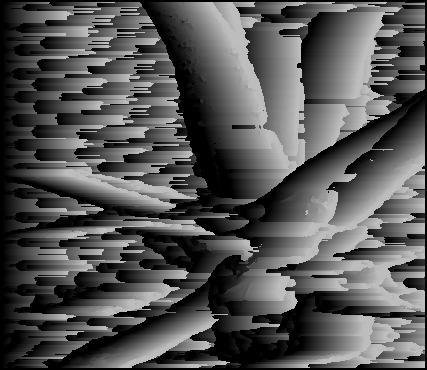

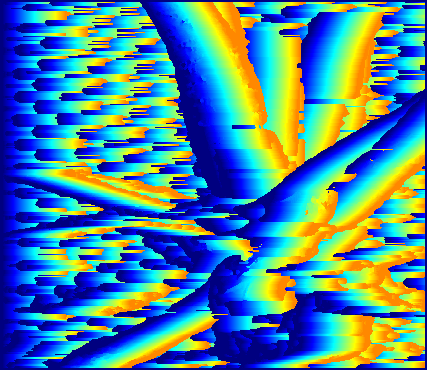

In [32]:
depth = window_based_matching_l1(
    left_img_path,
    right_img_path,
    disparity_range,
    kernel_size=kernel_size,
    save_result=False
)
cv2_imshow(depth)
cv2_imshow(cv2.applyColorMap(depth, cv2.COLORMAP_JET))

100%|██████████| 366/366 [05:21<00:00,  1.14it/s]

Saving result...
Done.


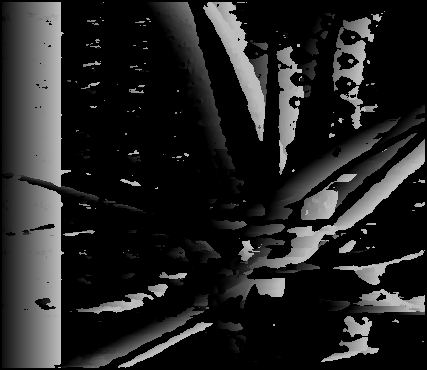

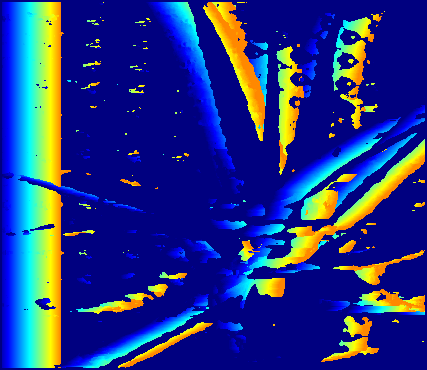

In [33]:
depth = window_based_matching_l2(
    left_img_path,
    right_img_path,
    disparity_range,
    kernel_size=kernel_size,
    save_result=False
)
cv2_imshow(depth)
cv2_imshow(cv2.applyColorMap(depth, cv2.COLORMAP_JET))

# Problem 4: Window-based matching with Cosine similarity

In [34]:
def cosine_similarity(x, y):
    numerator = np.dot(x, y)
    denominator = np.linalg.norm(x) * np.linalg.norm(y)

    return numerator / denominator

In [35]:
def window_based_matching(left_img, right_img, disparity_range, kernel_size=5, save_result=True):
    # Read left, right images then convert to grayscale
    left  = cv2.imread(left_img, 0)
    right = cv2.imread(right_img, 0)

    left  = left.astype(np.float32)
    right = right.astype(np.float32)

    height, width = left.shape[:2]

    # Create blank disparity map
    depth = np.zeros((height, width), np.uint8)
    kernel_half = int((kernel_size - 1) / 2)
    scale = 3

    for y in range(kernel_half, height-kernel_half):
        for x in range(kernel_half, width-kernel_half):
            # Find j where cost has minimum value
            disparity = 0
            cost_optimal  = -1

            for j in range(disparity_range):
                d = x - j
                cost = -1
                if (d - kernel_half) > 0:
                    wp = left[(y-kernel_half):(y+kernel_half)+1, (x-kernel_half):(x+kernel_half)+1]
                    wqd = right[(y-kernel_half):(y+kernel_half)+1, (d-kernel_half):(d+kernel_half)+1]

                    wp_flattened = wp.flatten()
                    wqd_flattened = wqd.flatten()

                    cost = cosine_similarity(wp_flattened, wqd_flattened)

                if cost > cost_optimal:
                    cost_optimal = cost
                    disparity = j

            # Let depth at (y, x) = j (disparity)
            # Multiply by a scale factor for visualization purpose
            depth[y, x] = disparity * scale

    if save_result == True:
        print('Saving result...')
        # Save results
        cv2.imwrite('window_based_cosine_similarity.png', depth)
        cv2.imwrite('window_based_cosine_similarity_color.png', cv2.applyColorMap(depth, cv2.COLORMAP_JET))

    print('Done.')

    return depth

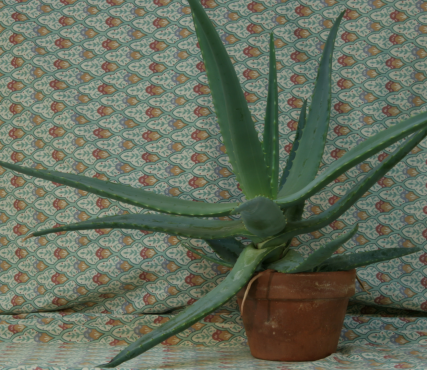

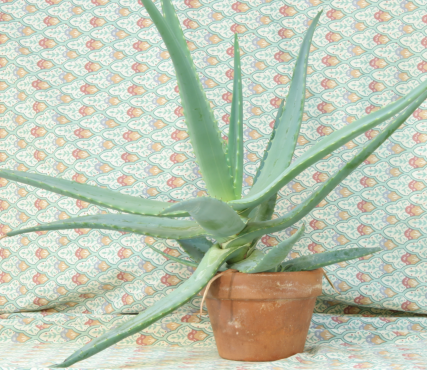

In [36]:
left_img_path = 'Aloe/Aloe_left_1.png'
right_img_path = 'Aloe/Aloe_right_2.png'
disparity_range = 64
kernel_size = 5

left = cv2.imread(left_img_path)
right = cv2.imread(right_img_path)

cv2_imshow(left)
cv2_imshow(right)

Done.


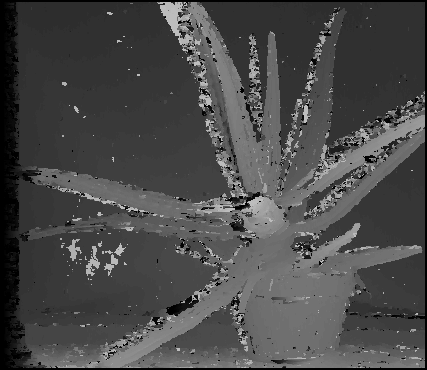

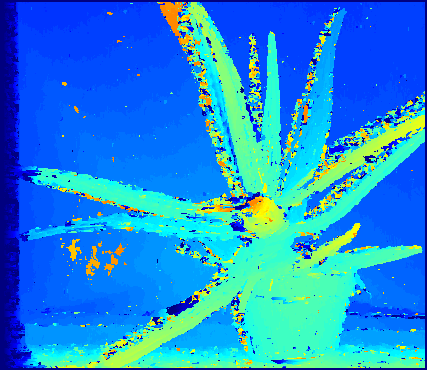

In [37]:
depth = window_based_matching(
    left_img_path,
    right_img_path,
    disparity_range,
    kernel_size=kernel_size,
    save_result=False
)
cv2_imshow(depth)
cv2_imshow(cv2.applyColorMap(depth, cv2.COLORMAP_JET))